# Download and load the data


In [1]:
pip install "datasets<3.0"

/Users/nicolas/studia/2_sem/MLOps/lab6/.venv/bin/python: No module named pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
device = 'cuda' if torch.cuda.is_available() else "mpu"

In [3]:
device

'mpu'

In [4]:
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt

dataset = load_dataset("PolyAI/banking77")

In [5]:
df_train = dataset["train"].to_pandas()

## Initial exploration and cleaning


### Check data types


In [6]:
df_train["label"] = pd.to_numeric(df_train["label"], downcast="integer")
df_train = df_train.astype({"text": str})

The dataset does not contain any missing values.

Label was originally int64, so I downcasted it to int8 to save memory.


In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10003 entries, 0 to 10002
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    10003 non-null  object
 1   label   10003 non-null  int8  
dtypes: int8(1), object(1)
memory usage: 88.0+ KB


### Class distribution


The labels aren't distributed equally - some labels have significantly more samples than others.

The most frequent label is 15 ( card_payment_fee_charged) with 187 samples, while the least frequent label is 23 (contactless_not_working) with 35 samples.


In [8]:
df_train["label"].value_counts()

label
15    187
28    182
6     181
75    180
19    177
     ... 
41     82
18     61
10     59
72     41
23     35
Name: count, Length: 77, dtype: int64

### Histograms of text lengths


Most of the texts are up to 50 characters long, decreasing drastically after 100 characters.


<Axes: >

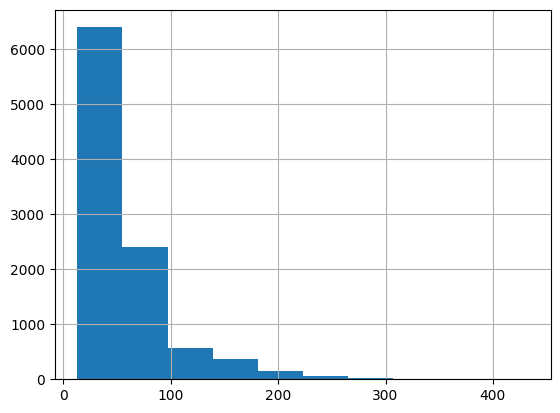

In [9]:
df_train["text"].str.len().hist()

# Use CleanLab to detect and fix data quality issues


In [10]:
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import LogisticRegressionCV
import numpy as np
from sklearn.model_selection import cross_val_predict


def get_initial_model_data(
    texts: np.ndarray, labels: np.ndarray
) -> tuple[np.ndarray, np.ndarray]:

    transformer = SentenceTransformer("all-MiniLM-L6-v2")
    embeddings = transformer.encode(texts)
    lr = LogisticRegressionCV(class_weight="balanced")
    pred_probs = cross_val_predict(lr, embeddings, labels, method="predict_proba")

    return embeddings, pred_probs


In [11]:
texts: np.ndarray = np.array(df_train["text"].values)
labels: np.ndarray = np.array(df_train["label"].values)

embeddings, pred_probs = get_initial_model_data(texts, labels)

In [12]:
pip install cleanlab

/Users/nicolas/studia/2_sem/MLOps/lab6/.venv/bin/python: No module named pip


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [13]:
from cleanlab import Datalab

data_dict = {"texts": texts, "labels": labels}
lab = Datalab(df_train[["text", "label"]], "classification")
lab.find_issues(pred_probs=pred_probs, features=embeddings)

Finding null issues ...
Finding outlier issues ...
Finding near_duplicate issues ...
Finding non_iid issues ...
Finding underperforming_group issues ...
Error in underperforming_group: boolean index did not match indexed array along dimension 0; dimension is 0 but corresponding boolean dimension is 10003
Failed to check for these issue types: [UnderperformingGroupIssueManager]

Audit complete. 482 issues found in the dataset.


In [14]:
lab.report()

Dataset Information: num_examples: 10003

Here is a summary of various issues found in your data:

    issue_type  num_issues
near_duplicate         350
       outlier         131
       non_iid           1

Learn about each issue: https://docs.cleanlab.ai/stable/cleanlab/datalab/guide/issue_type_description.html
See which examples in your dataset exhibit each issue via: `datalab.get_issues(<ISSUE_NAME>)`

Data indices corresponding to top examples of each issue are shown below.


------------------ near_duplicate issues -------------------

About this issue:
	A (near) duplicate issue refers to two or more examples in
    a dataset that are extremely similar to each other, relative
    to the rest of the dataset.  The examples flagged with this issue
    may be exactly duplicated, or lie atypically close together when
    represented as vectors (i.e. feature embeddings).
    

Number of examples with this issue: 350
Overall dataset quality in terms of this issue: 0.5981

Examples repre

In [15]:
duplicate_issues = lab.get_issues("near_duplicate")
duplicate_issues = duplicate_issues[duplicate_issues["is_near_duplicate_issue"]]
duplicate_issues = duplicate_issues.sort_values(by="near_duplicate_score")
duplicate_issues

,is_near_duplicate_issue,near_duplicate_score,near_duplicate_sets,distance_to_nearest_neighbor
1710,True,0.000000,[1724],0.000000
1290,True,0.000000,[1246],0.000000
1246,True,0.000000,[1290],0.000000
4594,True,0.000000,[4595],0.000000
4595,True,0.000000,[4594],0.000000
...,...,...,...,...
4403,True,0.121103,[4437],0.011252
4437,True,0.121103,[4403],0.011252
2309,True,0.121141,[2237],0.011256
2237,True,0.121141,[2309],0.011256


In [16]:
outlier_issues = lab.get_issues("outlier")
outlier_issues = outlier_issues[outlier_issues["is_outlier_issue"]]
outlier_issues = outlier_issues.sort_values(by="outlier_score", ascending=False)
outlier_issues

,is_outlier_issue,outlier_score
4847,True,0.075601
3309,True,0.075278
9183,True,0.075155
3784,True,0.074852
4826,True,0.074240
...,...,...
93,True,0.008737
4655,True,0.007935
8802,True,0.007870
4633,True,0.006303


In [17]:
for idx, row in outlier_issues.reset_index()[:5].iterrows():
    original_idx = row["index"]

    print(f"\n{'=' * 80}")
    print(f"Outlying row {original_idx}")
    print(f"{'=' * 80}")

    print(f"Label: {df_train.iloc[original_idx]['label']}")
    print(f"Text: {df_train.iloc[original_idx]['text']}")


Outlying row 4847
Label: 44
Text: passcode retrieval

Outlying row 3309
Label: 6
Text: I made a deposit a couple of days back it's, as of yet, not gone in! It would be ideal if you assist me with this

Outlying row 9183
Label: 0
Text: I tried activating my plug-in and it didn't piece of work

Outlying row 3784
Label: 74
Text: Why are you asking so many questions about who I am

Outlying row 4826
Label: 44
Text: I forgot my code


## Analyze duplicates


In [18]:
for idx, row in duplicate_issues.reset_index()[:5].iterrows():
    original_idx = row["index"]
    duplicate_indices = row["near_duplicate_sets"]

    print(f"\n{'=' * 80}")
    print(
        f"Pair {idx + 1}: Original index {original_idx} vs Duplicates {duplicate_indices}"
    )
    print(f"{'=' * 80}")

    print(f"\n[Original - Index {original_idx}]")
    print(f"Label: {df_train.iloc[original_idx]['label']}")
    print(f"Text: {df_train.iloc[original_idx]['text']}")

    for dup_idx in duplicate_indices:
        print(f"\n[Duplicate - Index {dup_idx}]")
        print(f"Label: {df_train.iloc[dup_idx]['label']}")
        print(f"Text: {df_train.iloc[dup_idx]['text']}")



Pair 1: Original index 1710 vs Duplicates [1724]

[Original - Index 1710]
Label: 49
Text: 
I put the wrong pin too many times and now it is blocked. Can you help me unblock it?

[Duplicate - Index 1724]
Label: 49
Text: I put the wrong pin too many times and now it is blocked. Can you help me unblock it?

Pair 2: Original index 1290 vs Duplicates [1246]

[Original - Index 1290]
Label: 14
Text: 
I can't seem to be able to use my card




[Duplicate - Index 1246]
Label: 14
Text: I can't seem to be able to use my card

Pair 3: Original index 1246 vs Duplicates [1290]

[Original - Index 1246]
Label: 14
Text: I can't seem to be able to use my card

[Duplicate - Index 1290]
Label: 14
Text: 
I can't seem to be able to use my card




Pair 4: Original index 4594 vs Duplicates [4595]

[Original - Index 4594]
Label: 3
Text: Where can I withdraw money from?

[Duplicate - Index 4595]
Label: 3
Text: 
Where can I withdraw money from?

Pair 5: Original index 4595 vs Duplicates [4594]

[Original - Ind

My results do not agree with [the paper](https://aclanthology.org/2022.insights-1.19/), mainly because the DataLab didn't detect any label issues that are mentioned in the paper.

In my opinion, the problems are worth fixing, especially the mislabeled texts.


### Remove duplicates


In [19]:
all_pairs = set()

for _, row in duplicate_issues.iterrows():
    dups = row["near_duplicate_sets"]
    for dup in dups:
        pair = tuple(sorted([dup, dups[0]]))
        all_pairs.add(pair)

indices_to_remove = [max(pair) for pair in all_pairs]


In [20]:
train_df_cleaned = df_train.drop(indices_to_remove)

In [21]:
len(train_df_cleaned)

9667

# Train a small text classifier

In [22]:
from sklearn.model_selection import train_test_split

train_df, valid_df = train_test_split(
    train_df_cleaned, test_size=0.2, random_state=42, stratify=train_df_cleaned["label"]
)

In [23]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")


def tokenize(examples):
    return tokenizer(examples["text"], padding=True, truncation=True)

In [24]:
from datasets import Dataset

train_dataset = Dataset.from_pandas(train_df).map(tokenize, batched=True)
valid_dataset = Dataset.from_pandas(valid_df).map(tokenize, batched=True)

Map:   0%|          | 0/7733 [00:00<?, ? examples/s]

Map:   0%|          | 0/1934 [00:00<?, ? examples/s]

In [56]:
from transformers import AutoModelForSequenceClassification

num_labels = train_df_cleaned["label"].nunique()
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-uncased", num_labels=num_labels
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [57]:
from sklearn.metrics import f1_score


def compute_metrics(eval_pred):
    logits = eval_pred.predictions
    labels = eval_pred.label_ids

    # For multiclass: get predicted class
    y_pred = np.argmax(logits, axis=1)

    # F1-score with macro averaging for multiclass
    f1 = f1_score(labels, y_pred, average="macro")

    return {"f1": f1}

I need to use lower learning rate than provided, because otherwise the model would overfit and predict only about 6 classes out of 77.

In [58]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="finetuned_banking77",
    learning_rate=1e-5,
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    seed=42,
    logging_steps=50,
)


In [59]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)


In [60]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,3.398100,3.134132,0.467368
2,2.337200,2.107287,0.641839
3,1.568100,1.441437,0.728301
4,1.183800,1.032811,0.803744
5,0.855500,0.790605,0.839250
6,0.669700,0.651966,0.870645
7,0.512400,0.571532,0.876641
8,0.451200,0.522808,0.881980
9,0.436900,0.496595,0.881583
10,0.425200,0.487641,0.881402


TrainOutput(global_step=4840, training_loss=1.3364785308680258, metrics={'train_runtime': 856.9036, 'train_samples_per_second': 90.244, 'train_steps_per_second': 5.648, 'total_flos': 1939719152450724.0, 'train_loss': 1.3364785308680258, 'epoch': 10.0})

In [61]:
predictions = trainer.predict(valid_dataset)
logits = predictions.predictions
y_true = predictions.label_ids

# Test the resulting model

In [62]:
import torch

y_pred = np.argmax(logits, axis=1)
y_pred_proba = torch.softmax(torch.tensor(logits), dim=1).numpy()

In [63]:
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    precision_score,
    recall_score,
)

print("=" * 80)
print("OVERALL METRICS")
print("=" * 80)

accuracy = accuracy_score(y_true, y_pred)
f1_macro = f1_score(y_true, y_pred, average="macro")
precision_macro = precision_score(y_true, y_pred, average="macro")
recall_macro = recall_score(y_true, y_pred, average="macro")
auroc_ovo = roc_auc_score(y_true, y_pred_proba, multi_class="ovo", average="macro")

print(f"Accuracy:       {accuracy:.4f}")
print(f"F1-score:       {f1_macro:.4f}")
print(f"Precision:      {precision_macro:.4f}")
print(f"Recall:         {recall_macro:.4f}")
print(f"AUROC (OvO):    {auroc_ovo:.4f}")

OVERALL METRICS
Accuracy:       0.8914
F1-score:       0.8820
Precision:      0.8873
Recall:         0.8828
AUROC (OvO):    0.9974


## Commentary to the results

The overall F1-score is highly comparable with the paper - I achieved 0.882 whereas in the paper, the researches achieved F1-score of 0.878.

The score is high enough from my perspective, especially considering the fact that there are 77 classes in total.

Generally, the F1-score between classes is focused around the mean, although there are some huge outliers like class 37 which had F1-score of around 0.6 and class 72, which had F1-score of 0.

In [64]:
print("\n" + "=" * 80)
print("PER-CLASS METRICS")
print("=" * 80)

f1_per_class = f1_score(y_true, y_pred, average=None)
print(f"\nF1-score per class ({num_labels} classes):")
print(f"Min:  {f1_per_class.min():.4f}")
print(f"Max:  {f1_per_class.max():.4f}")
print(f"Std:  {f1_per_class.std():.4f}")


PER-CLASS METRICS

F1-score per class (77 classes):
Min:  0.0000
Max:  1.0000
Std:  0.1248


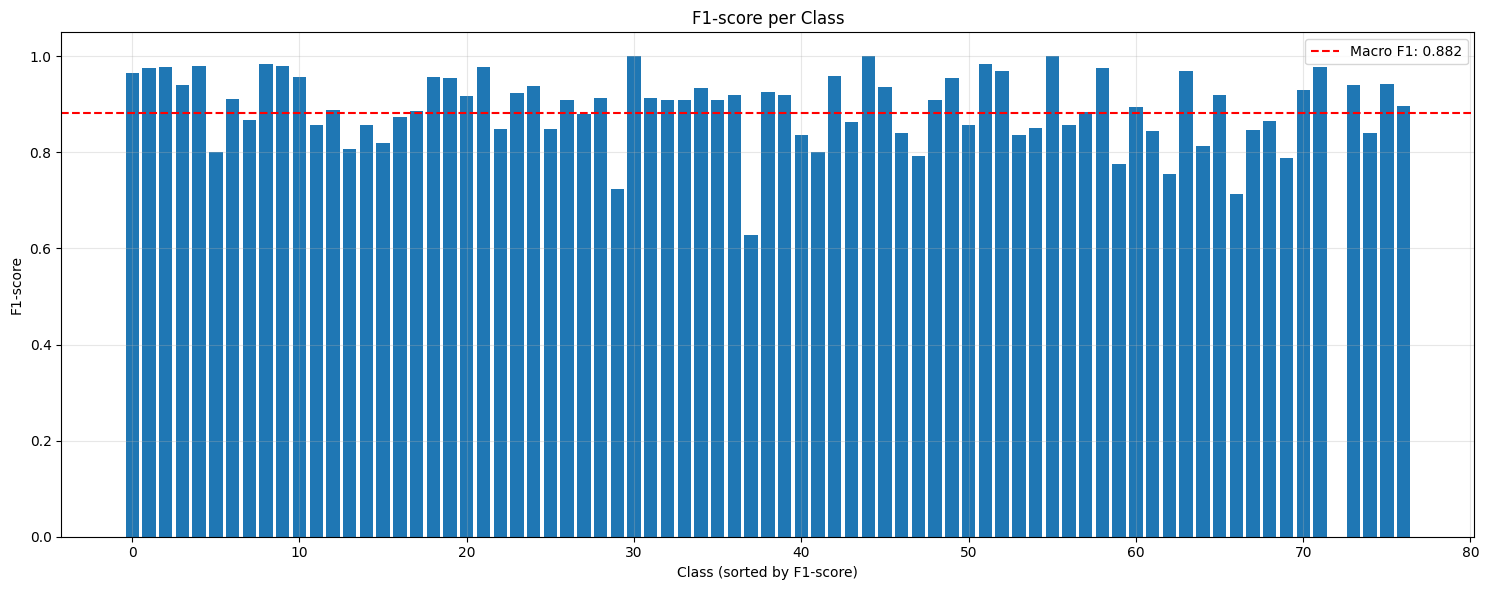

In [91]:
plt.figure(figsize=(15, 6))
plt.bar(range(len(f1_per_class)), f1_per_class)
plt.axhline(y=f1_macro, color="r", linestyle="--", label=f"Macro F1: {f1_macro:.3f}")
plt.xlabel("Class (sorted by F1-score)")
plt.ylabel("F1-score")
plt.title("F1-score per Class")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

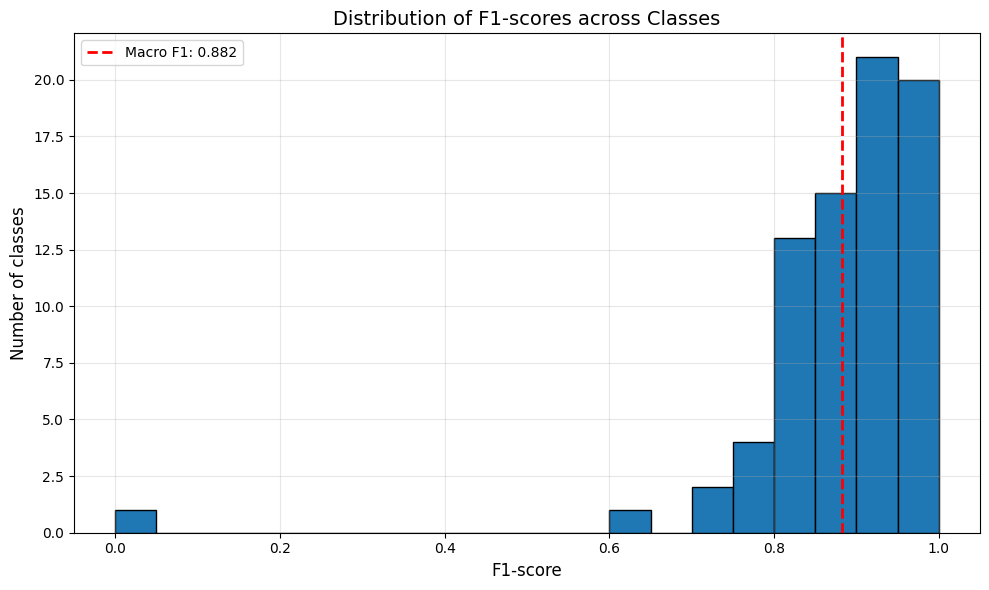

In [66]:
plt.figure(figsize=(10, 6))
plt.hist(f1_per_class, bins=20, edgecolor="black")
plt.axvline(
    x=f1_macro,
    color="r",
    linestyle="--",
    linewidth=2,
    label=f"Macro F1: {f1_macro:.3f}",
)
plt.xlabel("F1-score", fontsize=12)
plt.ylabel("Number of classes", fontsize=12)
plt.title("Distribution of F1-scores across Classes", fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [67]:
worst_classes = np.argsort(f1_per_class)[:5]
best_classes = np.argsort(f1_per_class)[-5:]

print("\n" + "=" * 80)
print("BEST AND WORST PERFORMING CLASSES")
print("=" * 80)
print("\nWorst 5 classes:")
for cls in worst_classes:
    print(f"  Class {cls}: F1 = {f1_per_class[cls]:.4f}")

print("\nBest 5 classes:")
for cls in best_classes:
    print(f"  Class {cls}: F1 = {f1_per_class[cls]:.4f}")


BEST AND WORST PERFORMING CLASSES

Worst 5 classes:
  Class 72: F1 = 0.0000
  Class 37: F1 = 0.6286
  Class 66: F1 = 0.7143
  Class 29: F1 = 0.7234
  Class 62: F1 = 0.7556

Best 5 classes:
  Class 51: F1 = 0.9836
  Class 8: F1 = 0.9841
  Class 30: F1 = 1.0000
  Class 55: F1 = 1.0000
  Class 44: F1 = 1.0000


# Giskard for behavioral testing

## Modifying prediction_function appropriately

In [88]:
from transformers import pipeline

pipe = pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    device="cuda" if torch.cuda.is_available() else "cpu",
    top_k=None,
)

Device set to use cpu


In [69]:
def prediction_function(texts):
    if isinstance(texts, str):
        texts = [texts]

    predictions = pipe(texts)

    n_samples = len(predictions)
    n_classes = len(predictions[0])

    pred_probs = np.zeros((n_samples, n_classes))

    for i, sample_preds in enumerate(predictions):
        for pred in sample_preds:
            # Extract class index from 'LABEL_X' format
            class_idx = int(pred["label"].split("_")[1])
            pred_probs[i, class_idx] = pred["score"]

    return pred_probs

In [70]:
predictions

PredictionOutput(predictions=array([[-0.98146975, -1.3445061 , -0.7738578 , ...,  0.6613739 ,
        -2.2925036 , -2.303989  ],
       [-3.7040153 , -2.1517045 , -2.1304379 , ..., -1.3027889 ,
         0.24207321,  0.9043618 ],
       [-2.6407504 , -2.0692005 , -1.6568424 , ..., -1.4940332 ,
        -1.593371  ,  2.8484995 ],
       ...,
       [-0.06654727, -2.1900973 , -1.6266578 , ..., -0.8613808 ,
        -2.4617493 , -2.521848  ],
       [-2.561683  , -1.9078732 , -3.1323195 , ..., -1.3938975 ,
        -1.4612236 , -1.7799727 ],
       [-2.2386758 , -0.8355465 , -1.1525575 , ..., -1.1724999 ,
        -0.95478636, -1.4241089 ]], dtype=float32), label_ids=array([30, 19, 17, ..., 49, 66, 51]), metrics={'test_loss': 0.5228082537651062, 'test_f1': 0.8819798266727029, 'test_runtime': 3.9985, 'test_samples_per_second': 483.687, 'test_steps_per_second': 15.256})

In [71]:
from giskard import Model as GiskardModel, Dataset as GiskardDataset, scan

@torch.no_grad()
def prediction_function(df: pd.DataFrame) -> np.ndarray:
    texts = df["text"].tolist()
    
    predictions = pipe(texts)
    
    n_samples = len(predictions)
    n_classes = len(predictions[0])
    
    pred_probs = np.zeros((n_samples, n_classes))
    
    for i, sample_preds in enumerate(predictions):
        for pred_dict in sample_preds:
            class_idx = int(pred_dict['label'].split('_')[1])
            pred_probs[i, class_idx] = pred_dict['score']
    
    return pred_probs

# Create Giskard dataset and model
giskard_dataset = GiskardDataset(
    train_df_cleaned, target="label", name="Banking77 Training Data"
)

giskard_model = GiskardModel(
    model=prediction_function,
    model_type="classification",
    classification_labels=list(range(num_labels)),
    feature_names=["text"],
    name="DistilBERT Banking77 Classifier",
)

# Run scan
print("Running Giskard scan...")
scan_results = scan(giskard_model, giskard_dataset, verbose=True)
display(scan_results)

2025-11-22 18:03:45,006 pid:63940 MainThread giskard.datasets.base INFO     Your 'pandas.DataFrame' is successfully wrapped by Giskard's 'Dataset' wrapper class.
2025-11-22 18:03:45,006 pid:63940 MainThread giskard.models.automodel INFO     Your 'prediction_function' is successfully wrapped by Giskard's 'PredictionFunctionModel' wrapper class.
Running Giskard scan...
2025-11-22 18:03:45,021 pid:63940 MainThread giskard.datasets.base INFO     Casting dataframe columns from {'text': 'object'} to {'text': 'object'}
2025-11-22 18:03:45,113 pid:63940 MainThread giskard.utils.logging_utils INFO     Predicted dataset with shape (10, 2) executed in 0:00:00.100809
2025-11-22 18:03:45,117 pid:63940 MainThread giskard.datasets.base INFO     Casting dataframe columns from {'text': 'object'} to {'text': 'object'}
2025-11-22 18:03:45,125 pid:63940 MainThread giskard.utils.logging_utils INFO     Predicted dataset with shape (1, 2) executed in 0:00:00.010439
2025-11-22 18:03:45,128 pid:63940 MainThrea

<iframe id="scan-14412341520" srcdoc="<!doctype html>
<html lang="en">

<head>
 <title>Giskard Scan Results</title>
 <base target="_blank">
 <meta charset="utf-8">
 
<style>pre code.hljs{display:block;overflow-x:auto;padding:1em}code.hljs{padding:3px 5px}
/*!
 Theme: GitHub Dark
 Description: Dark theme as seen on github.com
 Author: github.com
 Maintainer: @Hirse
 Updated: 2021-05-15

 Outdated base version: https://github.com/primer/github-syntax-dark
 Current colors taken from GitHub's CSS
*/.hljs{background:#0d1117;color:#c9d1d9}.hljs-doctag,.hljs-keyword,.hljs-meta .hljs-keyword,.hljs-template-tag,.hljs-template-variable,.hljs-type,.hljs-variable.language_{color:#ff7b72}.hljs-title,.hljs-title.class_,.hljs-title.class_.inherited__,.hljs-title.function_{color:#d2a8ff}.hljs-attr,.hljs-attribute,.hljs-literal,.hljs-meta,.hljs-number,.hljs-operator,.hljs-selector-attr,.hljs-selector-class,.hljs-selector-id,.hljs-variable{color:#79c0ff}.hljs-meta .hljs-string,.hljs-regexp,.hljs-string{color:#a5d6ff}.hljs-built_in,.hljs-symbol{color:#ffa657}.hljs-code,.hljs-comment,.hljs-formula{color:#8b949e}.hljs-name,.hljs-quote,.hljs-selector-pseudo,.hljs-selector-tag{color:#7ee787}.hljs-subst{color:#c9d1d9}.hljs-section{color:#1f6feb;font-weight:700}.hljs-bullet{color:#f2cc60}.hljs-emphasis{color:#c9d1d9;font-style:italic}.hljs-strong{color:#c9d1d9;font-weight:700}.hljs-addition{background-color:#033a16;color:#aff5b4}.hljs-deletion{background-color:#67060c;color:#ffdcd7}.hljs-copy-wrapper{overflow:hidden;position:relative}.hljs-copy-button:focus,.hljs-copy-wrapper:hover .hljs-copy-button{transform:translateX(0)}.hljs-copy-button{background-color:#2d2b57;background-color:var(--hljs-theme-background);background-image:url('data:image/svg+xml;charset=utf-8,<svg xmlns="http://www.w3.org/2000/svg" width="16" height="16" fill="none" viewBox="0 0 24 24"><path fill="%23fff" fill-rule="evenodd" d="M6 5a1 1 0 0 0-1 1v14a1 1 0 0 0 1 1h12a1 1 0 0 0 1-1V6a1 1 0 0 0-1-1h-2a1 1 0 1 1 0-2h2a3 3 0 0 1 3 3v14a3 3 0 0 1-3 3H6a3 3 0 0 1-3-3V6a3 3 0 0 1 3-3h2a1 1 0 0 1 0 2H6Z" clip-rule="evenodd"/><path fill="%23fff" fill-rule="evenodd" d="M7 3a2 2 0 0 1 2-2h6a2 2 0 0 1 2 2v2a2 2 0 0 1-2 2H9a2 2 0 0 1-2-2V3Zm8 0H9v2h6V3Z" clip-rule="evenodd"/></svg>');background-position:50%;background-repeat:no-repeat;border:1px solid #ffffff22;border-radius:.25rem;color:#fff;height:2rem;position:absolute;right:1em;text-indent:-9999px;top:1em;transition:background-color .2s ease,transform .2s ease-out;width:2rem}.hljs-copy-button:hover{border-color:#ffffff44}.hljs-copy-button:active{border-color:#ffffff66}.hljs-copy-button[data-copied=true]{background-image:none;text-indent:0;width:auto}@media (prefers-reduced-motion){.hljs-copy-button{transition:none}}.hljs-copy-alert{clip:rect(0 0 0 0);-webkit-clip-path:inset(50%);clip-path:inset(50%);height:1px;overflow:hidden;position:absolute;white-space:nowrap;width:1px}
/*! tailwindcss v3.3.2 | MIT License | https://tailwindcss.com*/*,:after,:before{border:0 solid #e5e7eb;box-sizing:border-box}:after,:before{--tw-content:""}html{-webkit-text-size-adjust:100%;font-feature-settings:normal;font-family:ui-sans-serif,system-ui,-apple-system,BlinkMacSystemFont,Segoe UI,Roboto,Helvetica Neue,Arial,Noto Sans,sans-serif,Apple Color Emoji,Segoe UI Emoji,Segoe UI Symbol,Noto Color Emoji;font-variation-settings:normal;line-height:1.5;-moz-tab-size:4;-o-tab-size:4;tab-size:4}body{line-height:inherit;margin:0}hr{border-top-width:1px;color:inherit;height:0}abbr:where([title]){-webkit-text-decoration:underline dotted;text-decoration:underline dotted}h1,h2,h3,h4,h5,h6{font-size:inherit;font-weight:inherit}a{color:inherit;text-decoration:inherit}b,strong{font-weight:bolder}code,kbd,pre,samp{font-family:ui-monospace,SFMono-Regular,Menlo,Monaco,Consolas,Liberation Mono,Courier New,monospace;font-size:1em}small{font-size:80%}sub,sup{font-size:75%;line-height:0;position:relative;vertical-align:baseline}sub{bottom:-.25em}sup{top:-.5em}table{border-collapse:co

## Analyze the results

I would say, that there is additional problem with the model namely, it is either highly confident or uncertain about it's predictions. Mean standard deviation of around 0.2 is concerning from my point of view.

In [92]:
sample_df = valid_df.head(100)
pred_probs_test = prediction_function(sample_df)

In [93]:
print(f"Prediction shape: {pred_probs_test.shape}")
print(f"Sample prediction (first text): {pred_probs_test[0][:10]}...")
print(f"Probabilities sum to 1: {np.allclose(pred_probs_test.sum(axis=1), 1.0)}")

Prediction shape: (100, 77)
Sample prediction (first text): [0.00143034 0.00099489 0.00176037 0.00036297 0.00073866 0.00092711
 0.00070713 0.0005925  0.00077514 0.00081985]...
Probabilities sum to 1: True


In [94]:
all_preds = np.argmax(pred_probs_test, axis=1)
print(f"Predicted classes: {np.unique(all_preds)}")
print(f"Number of unique classes predicted: {len(np.unique(all_preds))}")

Predicted classes: [ 0  1  4  5  6  7  8  9 10 11 12 13 15 16 17 19 20 22 24 25 26 27 29 30
 32 33 35 36 37 38 39 40 42 43 44 45 47 48 49 50 51 52 53 55 57 58 60 61
 63 64 65 67 68 73 74 76]
Number of unique classes predicted: 56


In [95]:
max_probs = pred_probs_test.max(axis=1)
print("Prediction confidence:")
print(f"  Mean: {max_probs.mean():.4f}")
print(f"  Min:  {max_probs.min():.4f}")
print(f"  Max:  {max_probs.max():.4f}")
print(f"  Std:  {max_probs.std():.4f}")

Prediction confidence:
  Mean: 0.7345
  Min:  0.1807
  Max:  0.9339
  Std:  0.2021


In [ ]:
full_valid_preds = prediction_function(valid_df)
full_valid_pred_classes = np.argmax(full_valid_preds, axis=1)

predicted_classes = set(full_valid_pred_classes)
all_classes = set(range(num_labels))
never_predicted = all_classes - predicted_classes

print(f"Classes never predicted: {len(never_predicted)} out of {num_labels}")
if len(never_predicted) > 0:
    print(f"  Classes: {sorted(list(never_predicted))[:20]}...")



 Classes never predicted: 1 out of 77
  Classes: [72]...


# Captum for local explainability


In [79]:
# source https://www.unitxt.ai/en/main/catalog/catalog.cards.banking77.html
mapper = {
    "0": "activate my card",
    "1": "age limit",
    "2": "apple pay or google pay",
    "3": "atm support",
    "4": "automatic top up",
    "5": "balance not updated after bank transfer",
    "6": "balance not updated after cheque or cash deposit",
    "7": "beneficiary not allowed",
    "8": "cancel transfer",
    "9": "card about to expire",
    "10": "card acceptance",
    "11": "card arrival",
    "12": "card delivery estimate",
    "13": "card linking",
    "14": "card not working",
    "15": "card payment fee charged",
    "16": "card payment not recognised",
    "17": "card payment wrong exchange rate",
    "18": "card swallowed",
    "19": "cash withdrawal charge",
    "20": "cash withdrawal not recognised",
    "21": "change pin",
    "22": "compromised card",
    "23": "contactless not working",
    "24": "country support",
    "25": "declined card payment",
    "26": "declined cash withdrawal",
    "27": "declined transfer",
    "28": "direct debit payment not recognised",
    "29": "disposable card limits",
    "30": "edit personal details",
    "31": "exchange charge",
    "32": "exchange rate",
    "33": "exchange via app",
    "34": "extra charge on statement",
    "35": "failed transfer",
    "36": "fiat currency support",
    "37": "get disposable virtual card",
    "38": "get physical card",
    "39": "getting spare card",
    "40": "getting virtual card",
    "41": "lost or stolen card",
    "42": "lost or stolen phone",
    "43": "order physical card",
    "44": "passcode forgotten",
    "45": "pending card payment",
    "46": "pending cash withdrawal",
    "47": "pending top up",
    "48": "pending transfer",
    "49": "pin blocked",
    "50": "receiving money",
    "51": "Refund not showing up",
    "52": "request refund",
    "53": "reverted card payment?",
    "54": "supported cards and currencies",
    "55": "terminate account",
    "56": "top up by bank transfer charge",
    "57": "top up by card charge",
    "58": "top up by cash or cheque",
    "59": "top up failed",
    "60": "top up limits",
    "61": "top up reverted",
    "62": "topping up by card",
    "63": "transaction charged twice",
    "64": "transfer fee charged",
    "65": "transfer into account",
    "66": "transfer not received by recipient",
    "67": "transfer timing",
    "68": "unable to verify identity",
    "69": "verify my identity",
    "70": "verify source of funds",
    "71": "verify top up",
    "72": "virtual card not working",
    "73": "visa or mastercard",
    "74": "why verify identity",
    "75": "wrong amount of cash received",
    "76": "wrong exchange rate for cash withdrawal",
}

## Modify the explain_text function to accommodate multiclass classification

In [80]:
from torch import softmax
from copy import deepcopy
from captum.attr import InputXGradient, configure_interpretable_embedding_layer
from captum.attr import visualization as vis


class BERTModelWrapper(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, inputs, attention_mask):
        return self.model(inputs, attention_mask=attention_mask)[0]


def explain_text(model, text: str, y_true: int, target_class: int = None) -> None:
    # make sure we compute gradients as necessary
    for param in model.distilbert.parameters():
        param.requires_grad = True

    model = model.cpu()

    tokenizer_output = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        return_attention_mask=True,
        return_tensors="pt",
    ).to("cpu")

    tokens = tokenizer.convert_ids_to_tokens(tokenizer_output["input_ids"][0])

    with torch.no_grad():
        logits = model(**tokenizer_output).logits
        y_pred_proba = softmax(logits, dim=1)[0]
        y_pred = int(torch.argmax(y_pred_proba).item())

    if target_class is None:
        target_class = y_pred

    target_class = int(target_class)
    y_true = int(y_true)

    model_copy = deepcopy(model)
    interpretable_embedding_layer = configure_interpretable_embedding_layer(
        model_copy, "distilbert.embeddings"
    )
    input_embeddings = interpretable_embedding_layer.indices_to_embeddings(
        tokenizer_output["input_ids"]
    )

    model_wrapper = BERTModelWrapper(model_copy)
    input_x_gradient = InputXGradient(model_wrapper)
    attributions = input_x_gradient.attribute(
        input_embeddings,
        target=target_class,
        additional_forward_args=tokenizer_output["attention_mask"],
    )

    # mean normalization
    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    attributions = [float(attr) for attr in attributions]

    # Remove [CLS] and [SEP] tokens
    attributions = attributions[1:-1]
    tokens = tokens[1:-1]

    vis_record = vis.VisualizationDataRecord(
        word_attributions=attributions,
        pred_prob=y_pred_proba[target_class].item(),
        pred_class=y_pred,
        true_class=y_true,
        attr_class=target_class,
        attr_score=sum(attributions),
        raw_input_ids=tokens,
        convergence_score=0,
    )

    true_label = mapper[str(y_true)]
    pred_label = mapper[str(y_pred)]
    print(f"\nText: {text}")
    print(f"True class: {y_true}    Label: {true_label}")
    print(f"Predicted: {y_pred}     Label: {pred_label}")
    print(f"Explaining: {target_class}")
    print("Prediction probabilities (top 5):")
    top5_probs = torch.topk(y_pred_proba, 5)
    for prob, idx in zip(top5_probs.values, top5_probs.indices):
        pred_class = idx.item()
        class_label = mapper[str(pred_class)]
        print(f"  Class {idx.item()}: {class_label}    {prob.item():.4f}")

    vis.visualize_text([vis_record])

In [84]:
torch.set_default_device("cpu")

test_indices = {
    *np.where((y_true == y_pred) & (y_pred_proba.max(axis=1) > 0.8))[0][:2],
    *np.where(y_true != y_pred)[0][:4],
    *np.where(y_pred_proba.max(axis=1) < 0.5)[0][:4],
}

for idx in test_indices:
    text = valid_df.iloc[idx]["text"]
    true_label = valid_df.iloc[idx]["label"]
    pred_label = y_pred[idx]

    print("\n" + "=" * 80)
    print(f"Sample {idx}")
    print("=" * 80)

    explain_text(model, text, true_label, target_class=pred_label)

    if pred_label != true_label:
        print("\n[Also explaining TRUE class]")
        explain_text(model, text, true_label, target_class=true_label)


Sample 0

Text: How do I change my name?
True class: 30    Label: edit personal details
Predicted: 30     Label: edit personal details
Explaining: 30
Prediction probabilities (top 5):
  Class 30: edit personal details    0.9106
  Class 74: why verify identity    0.0074
  Class 44: passcode forgotten    0.0042
  Class 55: terminate account    0.0039
  Class 33: exchange via app    0.0033


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
30,30 (0.91),30,-1.02,how do i change my name ?



Sample 1

Text: Why did you charge me extra when I withdrew cash?
True class: 19    Label: cash withdrawal charge
Predicted: 19     Label: cash withdrawal charge
Explaining: 19
Prediction probabilities (top 5):
  Class 19: cash withdrawal charge    0.9106
  Class 46: pending cash withdrawal    0.0110
  Class 76: wrong exchange rate for cash withdrawal    0.0078
  Class 15: card payment fee charged    0.0071
  Class 34: extra charge on statement    0.0070


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
19,19 (0.91),19,1.25,why did you charge me extra when i withdrew cash ?



Sample 4

Text: Should I order a new card before I freeze my original one?
True class: 22    Label: compromised card
Predicted: 13     Label: card linking
Explaining: 13
Prediction probabilities (top 5):
  Class 13: card linking    0.1807
  Class 39: getting spare card    0.1397
  Class 9: card about to expire    0.1380
  Class 41: lost or stolen card    0.1025
  Class 0: activate my card    0.0564


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
22,13 (0.18),13,0.54,should i order a new card before i freeze my original one ?



[Also explaining TRUE class]

Text: Should I order a new card before I freeze my original one?
True class: 22    Label: compromised card
Predicted: 13     Label: card linking
Explaining: 22
Prediction probabilities (top 5):
  Class 13: card linking    0.1807
  Class 39: getting spare card    0.1397
  Class 9: card about to expire    0.1380
  Class 41: lost or stolen card    0.1025
  Class 0: activate my card    0.0564


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
22,13 (0.03),22,0.33,should i order a new card before i freeze my original one ?



Sample 5

Text: Is there an issue with my card payment as it has not gone through.
True class: 25    Label: declined card payment
Predicted: 45     Label: pending card payment
Explaining: 45
Prediction probabilities (top 5):
  Class 45: pending card payment    0.7241
  Class 25: declined card payment    0.1076
  Class 53: reverted card payment?    0.0457
  Class 16: card payment not recognised    0.0096
  Class 59: top up failed    0.0064


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
25,45 (0.72),45,-0.15,is there an issue with my card payment as it has not gone through .



[Also explaining TRUE class]

Text: Is there an issue with my card payment as it has not gone through.
True class: 25    Label: declined card payment
Predicted: 45     Label: pending card payment
Explaining: 25
Prediction probabilities (top 5):
  Class 45: pending card payment    0.7241
  Class 25: declined card payment    0.1076
  Class 53: reverted card payment?    0.0457
  Class 16: card payment not recognised    0.0096
  Class 59: top up failed    0.0064


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
25,45 (0.11),25,0.53,is there an issue with my card payment as it has not gone through .



Sample 7

Text: why wasn't a transfer to account approved
True class: 7    Label: beneficiary not allowed
Predicted: 35     Label: failed transfer
Explaining: 35
Prediction probabilities (top 5):
  Class 35: failed transfer    0.3168
  Class 7: beneficiary not allowed    0.2122
  Class 27: declined transfer    0.1845
  Class 66: transfer not received by recipient    0.0892
  Class 48: pending transfer    0.0471


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
7,35 (0.32),35,-1.14,why wasn ' t a transfer to account approved



[Also explaining TRUE class]

Text: why wasn't a transfer to account approved
True class: 7    Label: beneficiary not allowed
Predicted: 35     Label: failed transfer
Explaining: 7
Prediction probabilities (top 5):
  Class 35: failed transfer    0.3168
  Class 7: beneficiary not allowed    0.2122
  Class 27: declined transfer    0.1845
  Class 66: transfer not received by recipient    0.0892
  Class 48: pending transfer    0.0471


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
7,35 (0.21),7,-0.48,why wasn ' t a transfer to account approved



Sample 10

Text: do i need to add money before i order a card
True class: 43    Label: order physical card
Predicted: 57     Label: top up by card charge
Explaining: 57
Prediction probabilities (top 5):
  Class 57: top up by card charge    0.2632
  Class 62: topping up by card    0.1217
  Class 43: order physical card    0.1118
  Class 54: supported cards and currencies    0.1062
  Class 58: top up by cash or cheque    0.0559


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
43,57 (0.26),57,1.58,do i need to add money before i order a card



[Also explaining TRUE class]

Text: do i need to add money before i order a card
True class: 43    Label: order physical card
Predicted: 57     Label: top up by card charge
Explaining: 43
Prediction probabilities (top 5):
  Class 57: top up by card charge    0.2632
  Class 62: topping up by card    0.1217
  Class 43: order physical card    0.1118
  Class 54: supported cards and currencies    0.1062
  Class 58: top up by cash or cheque    0.0559


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
43,57 (0.11),43,-1.73,do i need to add money before i order a card



Sample 19

Text: Why do you need to know so much about me for my account?
True class: 74    Label: why verify identity
Predicted: 74     Label: why verify identity
Explaining: 74
Prediction probabilities (top 5):
  Class 74: why verify identity    0.2566
  Class 30: edit personal details    0.2145
  Class 68: unable to verify identity    0.0723
  Class 55: terminate account    0.0419
  Class 16: card payment not recognised    0.0388


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
74,74 (0.26),74,0.39,why do you need to know so much about me for my account ?


## Is the model focusing on the right parts of texts?


Sometimes we can see that the model focuses extremely good like in sample 1, when the model focuses on words as [you, charge, extra, withdrew, cash] and the true and predicted label was "cash withdrawal charge".

Sometimes we can see a probable label mismatch like in sample 5, where:
- Text: Is there an issue with my card payment as it has not gone through.
- True Label: declined card payment
- Predicted Label: pending card payment

The model focuses on words [payment, not] when predicting, but also focuses on [card, has, gone, through] for the true label, which I don't think make that much of sense if the model in the same time doesn't focus on the word "not" (card has not gone through).
